<a href="https://colab.research.google.com/github/1rd0/18lab_bek/blob/master/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%96_8_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_ipynb__(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ФИО:**Рабдел Дмитрий Александрович


**Задание**   Создать модель для решения заядачи прогнозирования временных рядов с использованием фреймворка Keras.

В этой работе булем решать задачу прогнозирования временных рядов с использованием фреймворка Keras. В ноутбуке ниже приведен пример создания нейронной сети для прогнозирования курса акций (ссылка на датасет https://drive.google.com/file/d/1-KZEQkXhtGPSraSToJEkldZtGbZX30ap/view?usp=sharing).

В задании для самостоятельной разработки необходимо загрузить датасет и создать 3 архитектуры сети с использованием полносвязной архитектуры, одномерной свертки и рекуррентного слоя (MLP, Conv1D, LSTM).


**Основные понятия статистического анализа временных рядов:**

**Тренд** - компонента, описывающая долгосрочное изменение уровня ряда.

**Сезонность** - компонента, обозначаемая как Q, описывает циклические изменения уровня ряда.

**Ошибка **(random noise) - непрогнозируемая случайная компонента, описывает нерегулярные изменения в данных, необъяснимые другими компонентами.

**Автокорреляция** -статистическая взаимосвязь между последовательностями величин одного ряда. Это один из самых важных коэффициентов в анализе временного ряда. Чтобы посчитать автокорреляцию, используется корреляция между временным рядом и её сдвинутой копией от величины временного сдвига. Сдвиг ряда называется лагом.

**Автокорреляционная функция**- график автокорреляции при разных лагах.

**Стационарный ряд** - ряд, в котором свойства не зависят от времени.



**Импорт библиотек**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils

import numpy as np
from keras import layers
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D,  LSTM, GlobalMaxPooling1D, MaxPooling1D
import gdown

import os
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gdown
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

**Загрузка данных**

In [ ]:
base_data = pd.read_csv('/content/Course_1.csv', sep=';')
# Выведем информацию о датасете
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231


In [ ]:

base_data = pd.read_csv('/content/Course_1.csv', sep=';').drop(columns=['DATE', 'TIME']) # удалим лишние столбцы

In [ ]:
data =base_data.to_numpy()

In [ ]:
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume'] # Названия каналов для предсказания (столбцов)
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}

**Вывод графиков**

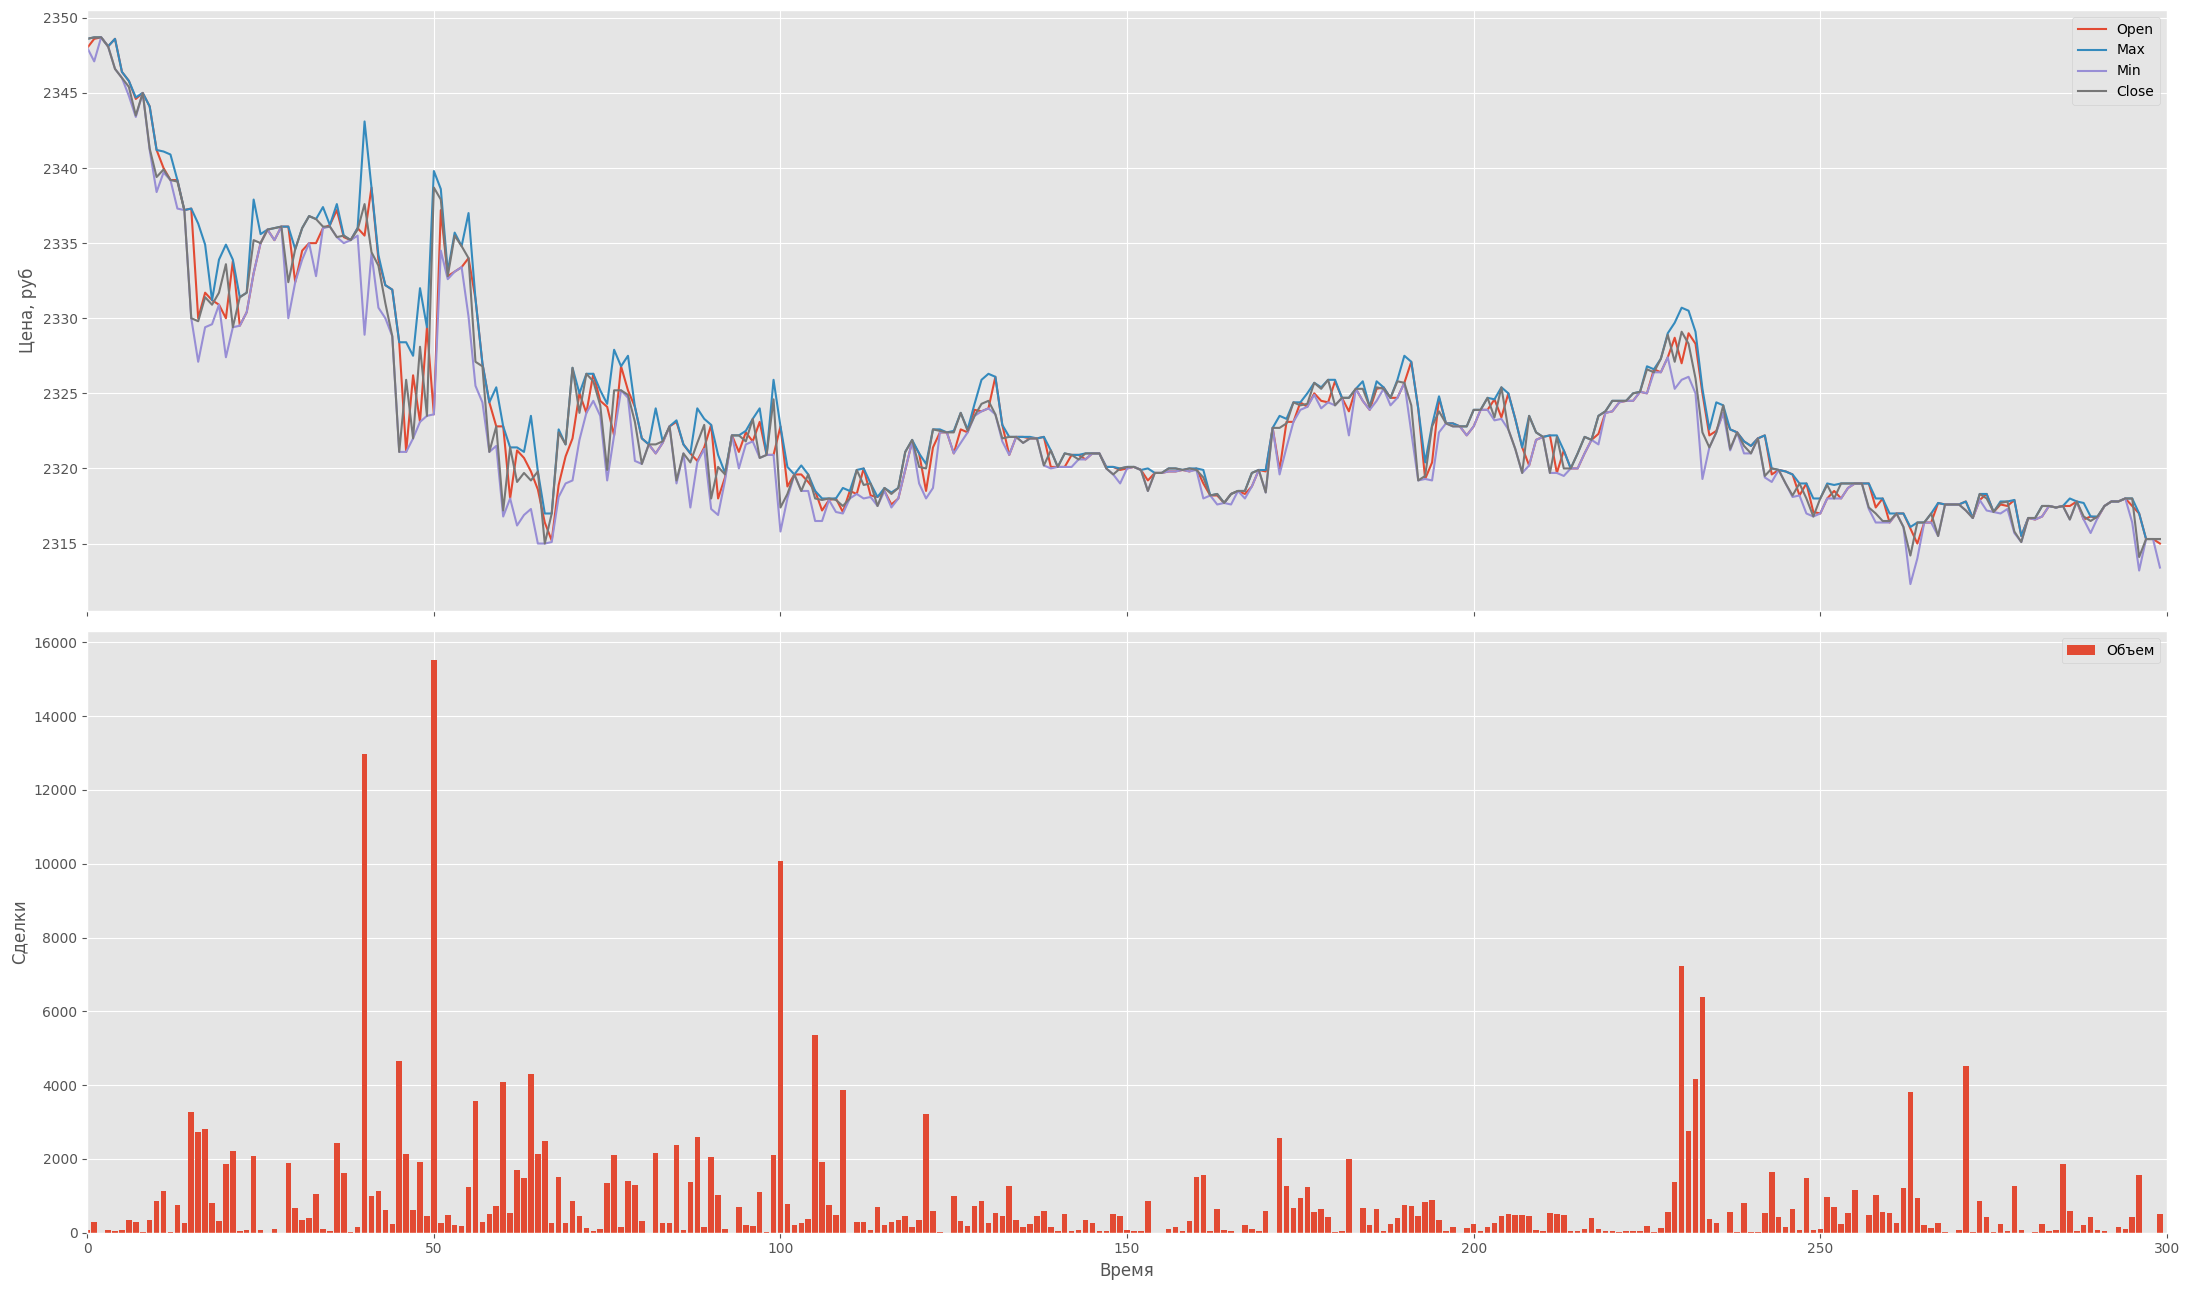

In [ ]:
# Выведем графики курса 'Open', 'Max', 'Min', 'Close', - на одном графике,  'Volume'- на другом
# Задание параметров, начальная точка и длина окна, которым будем проходить по ряду
start = 20
length = 300
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 13), sharex=True)
for chn in range(4):

    ax1.plot(data[start:start + length, chn],
             label=CHANNEL_NAMES[chn])
ax1.set_ylabel('Цена, руб')
ax1.legend()
# Канал volume (объем)
ax2.bar(x=np.arange(length),
        height=data[start:start + length, CHANNEL_INDEX['Volume']],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()
plt.xlabel('Время')
# Регулировка пределов оси x
plt.xlim(0, length)
plt.tight_layout()
plt.show()

In [ ]:
# Словарь каналов данных с их индексами
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 32                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

**Подготовка данных для обучения **.
Разделение данных на тренировочный и тестовый наборы, прохождение окном по наборам, масштабирование и создание генераторов обучающей и валидационной выбоки.

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

#  генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

[0, 1, 2, 3, 4] [3]
Train data: (233925, 5), (233925, 1)
Test  data: (29400, 5), (29400, 1)
Train batch x: (32, 300, 5), y: (32, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (29100, 300, 5), y: (29100, 1)


In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и денормализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
def eval_net(model,
             x_test, y_test,
             y_scaler,
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')


In [ ]:

def train_eval_net(model,
                   train_datagen, val_datagen,
                   epoch_list,
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    model.summary()

    for epochs, opt in epoch_list:
        model.compile(loss='mse', optimizer=opt)
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

**Создание и обучение полносвязной модели сети**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 300, 150)          900       
                                                                 
 flatten (Flatten)           (None, 45000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 45001     
                                                                 
Total params: 45901 (179.30 KB)
Trainable params: 45901 (179.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Обучение 10 эпох
Epoch 1/10
7301/7301 [==============================] - 31s 4ms/step - loss: 8.7031e-04 - val_loss: 4.7036e-05
Epoch 2/10
7301/7301 [==============================] - 28s 4ms/step - loss: 2.1355e-04 - val_loss: 3.1253e-04
Epoch 3/10
7301/7301 [===================

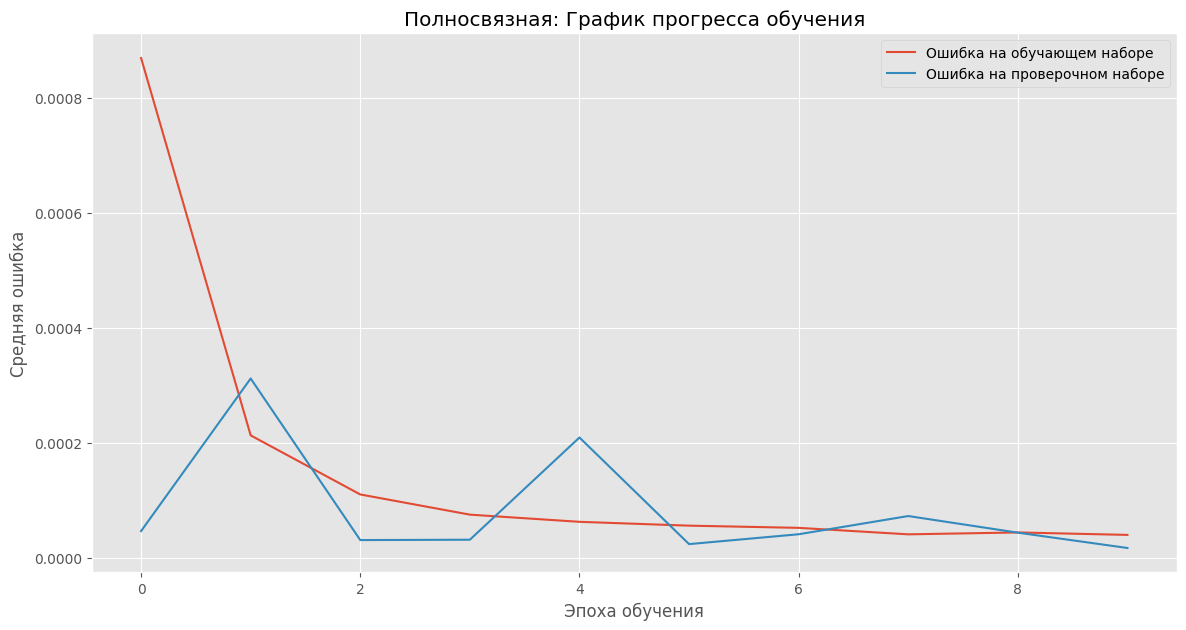

910/910 [==============================] - 2s 2ms/step


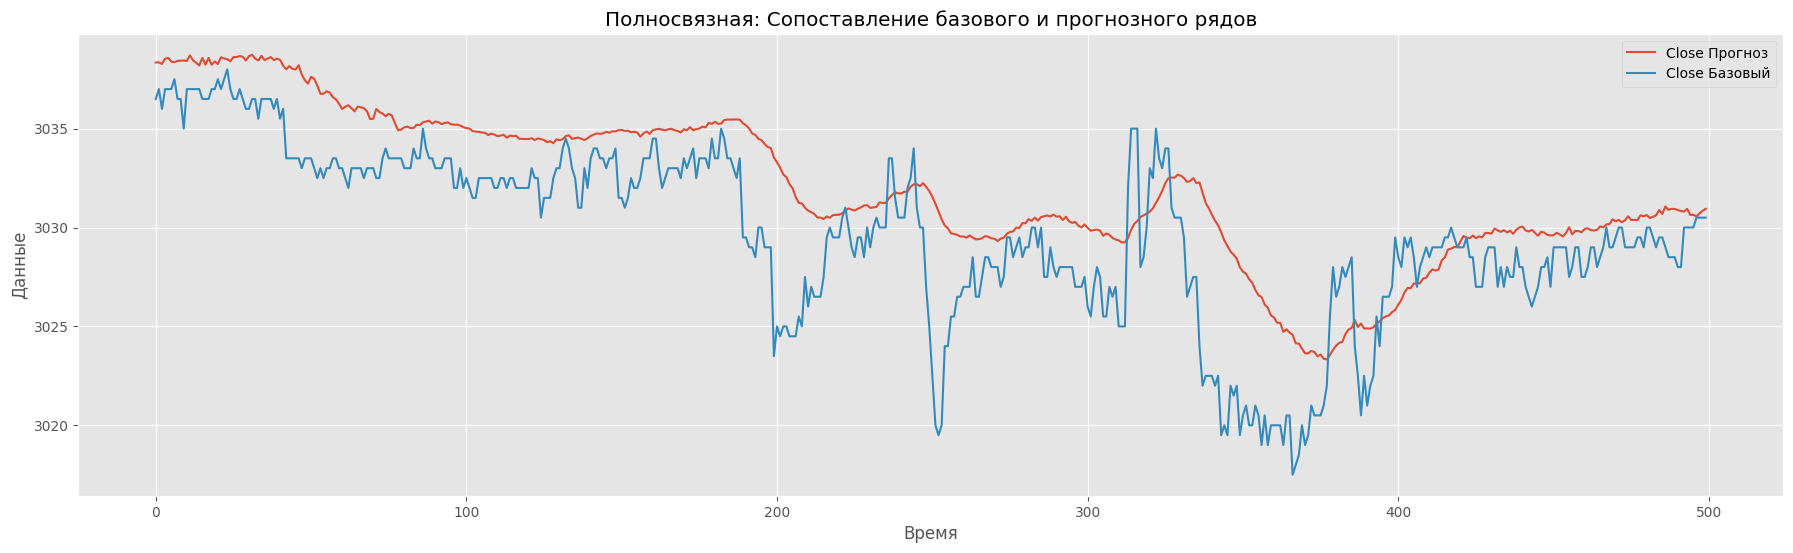

Обучение 25 эпох
Epoch 1/25
7301/7301 [==============================] - 30s 4ms/step - loss: 1.6210e-05 - val_loss: 4.2957e-05
Epoch 2/25
7301/7301 [==============================] - 29s 4ms/step - loss: 1.5580e-05 - val_loss: 1.2418e-05
Epoch 3/25
7301/7301 [==============================] - 29s 4ms/step - loss: 1.5342e-05 - val_loss: 3.3423e-05
Epoch 4/25
7301/7301 [==============================] - 29s 4ms/step - loss: 1.4838e-05 - val_loss: 1.3511e-05
Epoch 5/25
7301/7301 [==============================] - 29s 4ms/step - loss: 1.4543e-05 - val_loss: 1.4270e-05
Epoch 6/25
7301/7301 [==============================] - 30s 4ms/step - loss: 1.4182e-05 - val_loss: 1.1324e-05
Epoch 7/25
7301/7301 [==============================] - 30s 4ms/step - loss: 1.3921e-05 - val_loss: 1.4839e-05
Epoch 8/25
7301/7301 [==============================] - 33s 5ms/step - loss: 1.3708e-05 - val_loss: 1.2643e-05
Epoch 9/25
7301/7301 [==============================] - 30s 4ms/step - loss: 1.3468e-05 - val_l

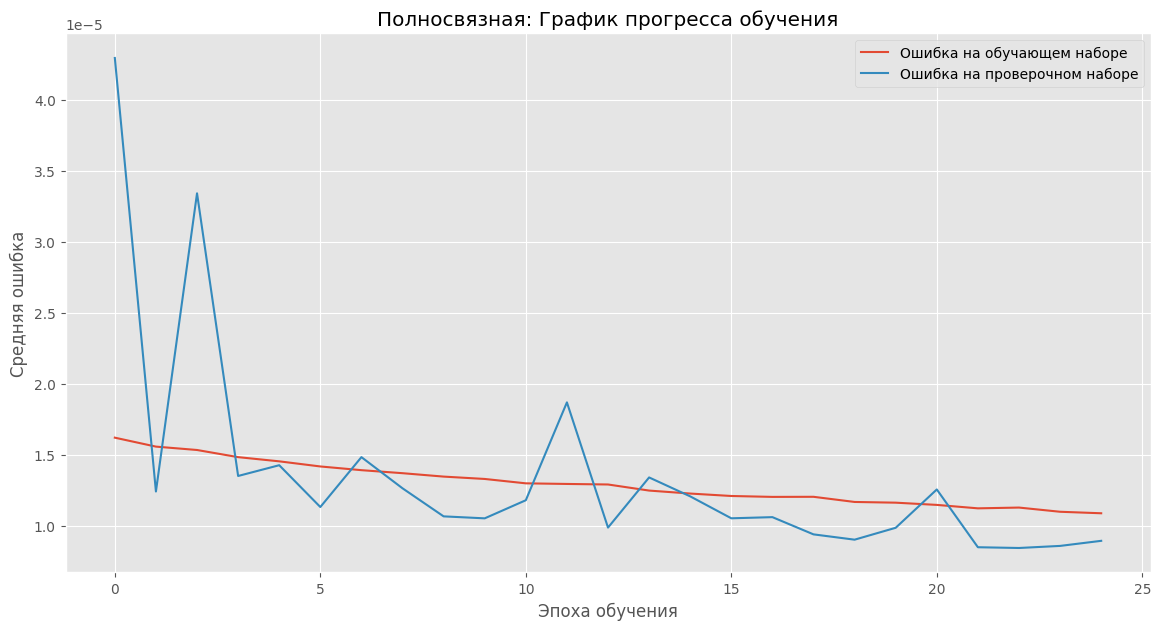

910/910 [==============================] - 2s 3ms/step


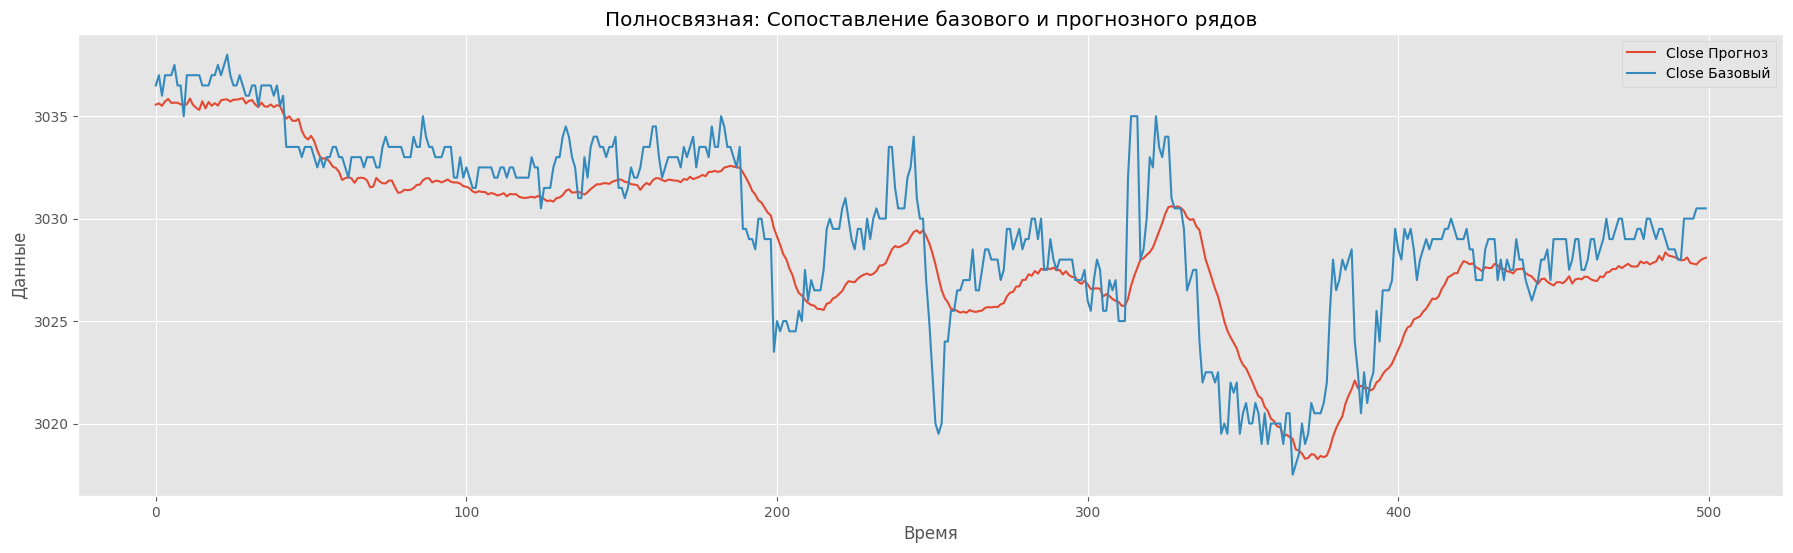

Обучение 25 эпох
Epoch 1/25
7301/7301 [==============================] - 32s 4ms/step - loss: 9.3524e-06 - val_loss: 8.5549e-06
Epoch 2/25
7301/7301 [==============================] - 30s 4ms/step - loss: 9.3520e-06 - val_loss: 8.0219e-06
Epoch 3/25
7301/7301 [==============================] - 31s 4ms/step - loss: 9.2881e-06 - val_loss: 7.9821e-06
Epoch 4/25
7301/7301 [==============================] - 31s 4ms/step - loss: 9.2726e-06 - val_loss: 8.9104e-06
Epoch 5/25
7301/7301 [==============================] - 31s 4ms/step - loss: 9.2705e-06 - val_loss: 7.9680e-06
Epoch 6/25
7301/7301 [==============================] - 35s 5ms/step - loss: 9.2507e-06 - val_loss: 7.9599e-06
Epoch 7/25
7301/7301 [==============================] - 31s 4ms/step - loss: 9.2132e-06 - val_loss: 8.4506e-06
Epoch 8/25
7301/7301 [==============================] - 31s 4ms/step - loss: 9.1874e-06 - val_loss: 8.6369e-06
Epoch 9/25
7301/7301 [==============================] - 40s 6ms/step - loss: 9.2046e-06 - val_l

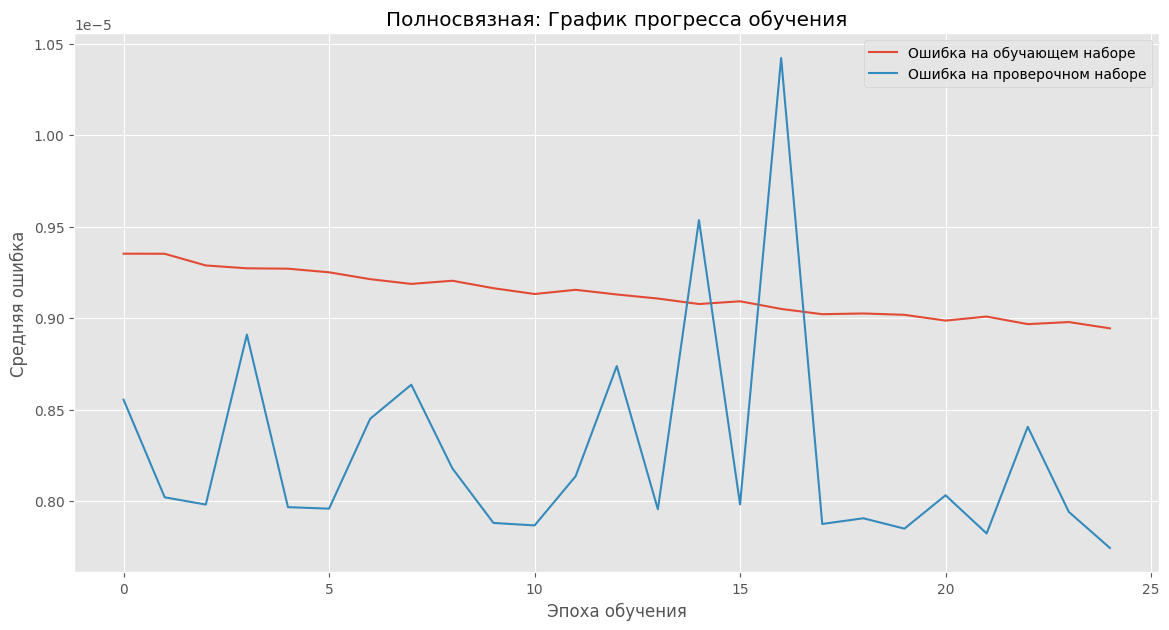

910/910 [==============================] - 2s 2ms/step


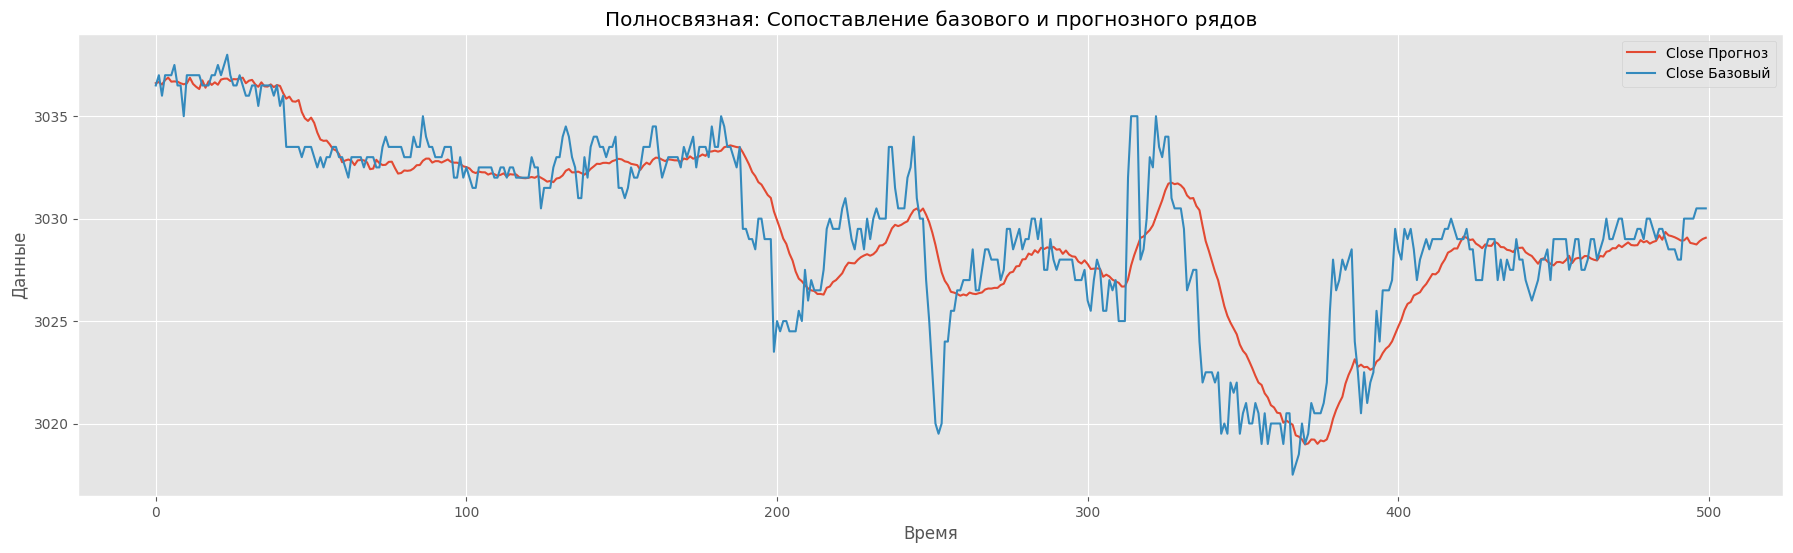

In [ ]:
model_dense = Sequential() # Модель MLP

model_dense.add(Dense(150, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))
 # Модель MLP обучение с разными значениями learning_rate и вывод графиков
train_eval_net(model_dense, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-4)),
                                                         (25, Adam(learning_rate =1e-5)),
                                                         (25, Adam(learning_rate =1e-6))],
               title='Полносвязная', x_test=x_test, y_test=y_test, y_scaler=y_scaler)

**Создание и обучение сети с использованием одномерной свертки**

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 296, 64)           1664      
                                                                 
 conv1d_11 (Conv1D)          (None, 292, 64)           20544     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 146, 64)           0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 9344)              0         
                                                                 
 dense_14 (Dense)            (None, 100)               934500    
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                     

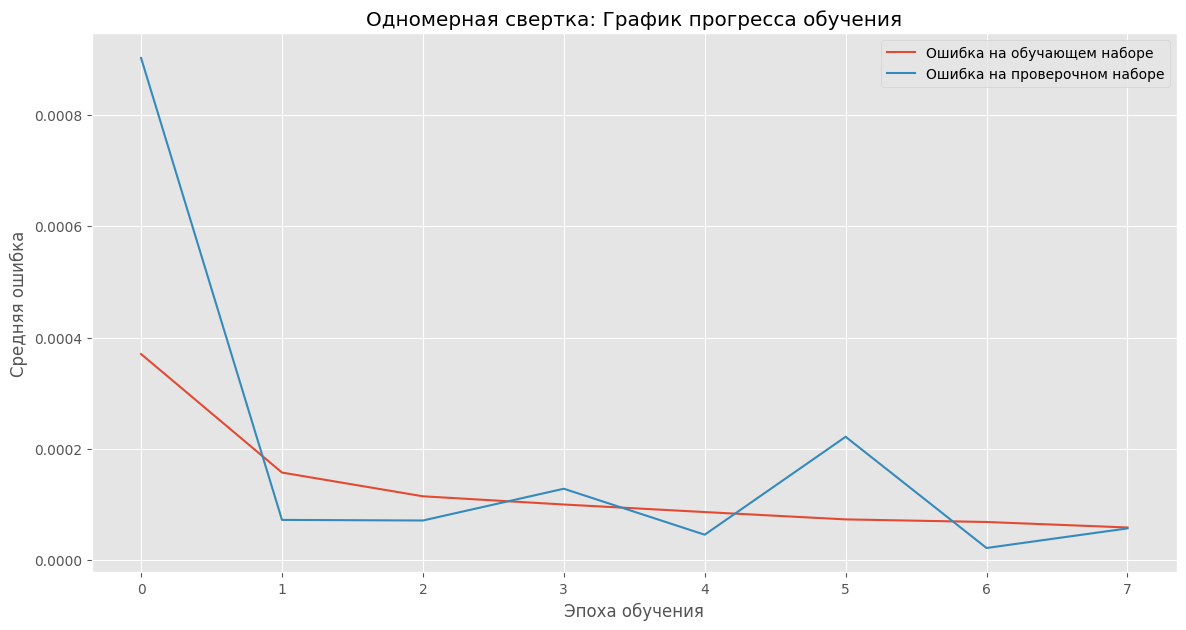

910/910 [==============================] - 2s 2ms/step


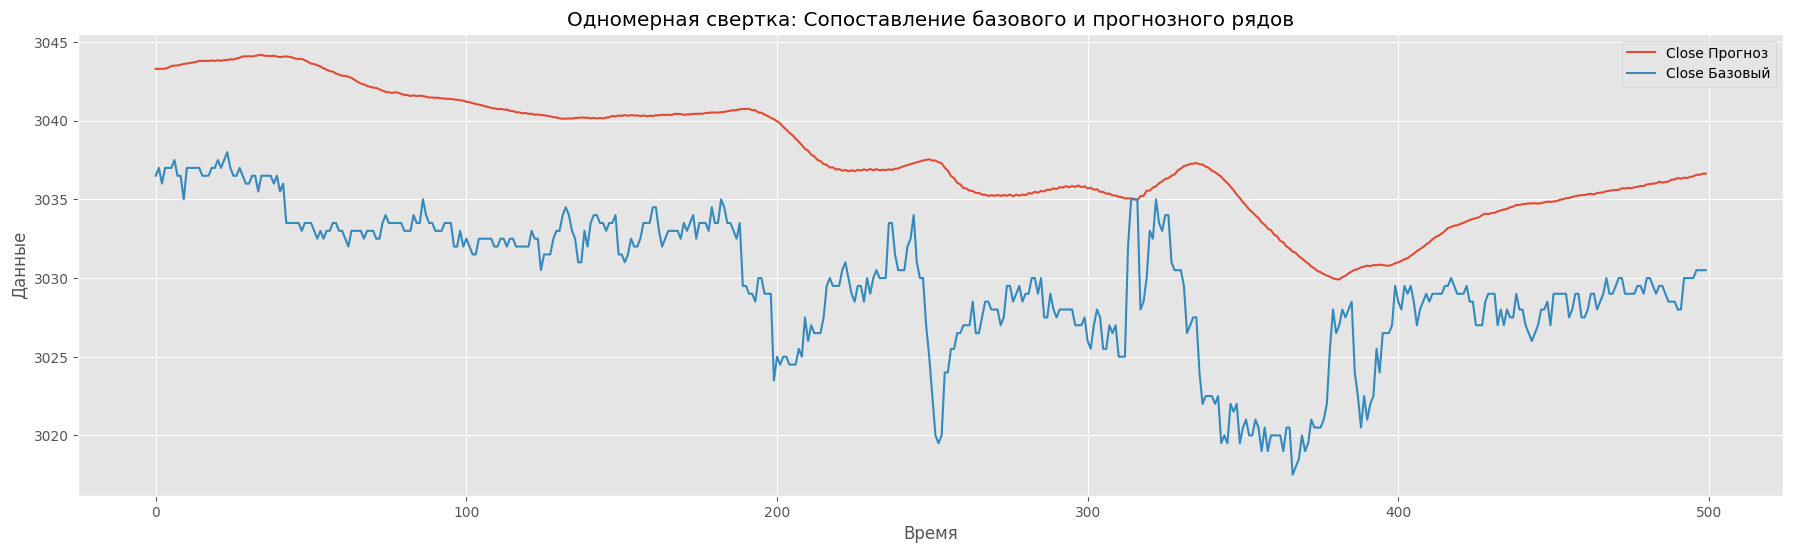

Обучение 5 эпох
Epoch 1/5
7301/7301 [==============================] - 36s 5ms/step - loss: 2.7387e-05 - val_loss: 3.2814e-05
Epoch 2/5
7301/7301 [==============================] - 35s 5ms/step - loss: 2.7009e-05 - val_loss: 3.0234e-05
Epoch 3/5
7301/7301 [==============================] - 35s 5ms/step - loss: 2.6459e-05 - val_loss: 2.4042e-05
Epoch 4/5
7301/7301 [==============================] - 35s 5ms/step - loss: 2.5922e-05 - val_loss: 3.8292e-05
Epoch 5/5
7301/7301 [==============================] - 36s 5ms/step - loss: 2.5521e-05 - val_loss: 1.9838e-05


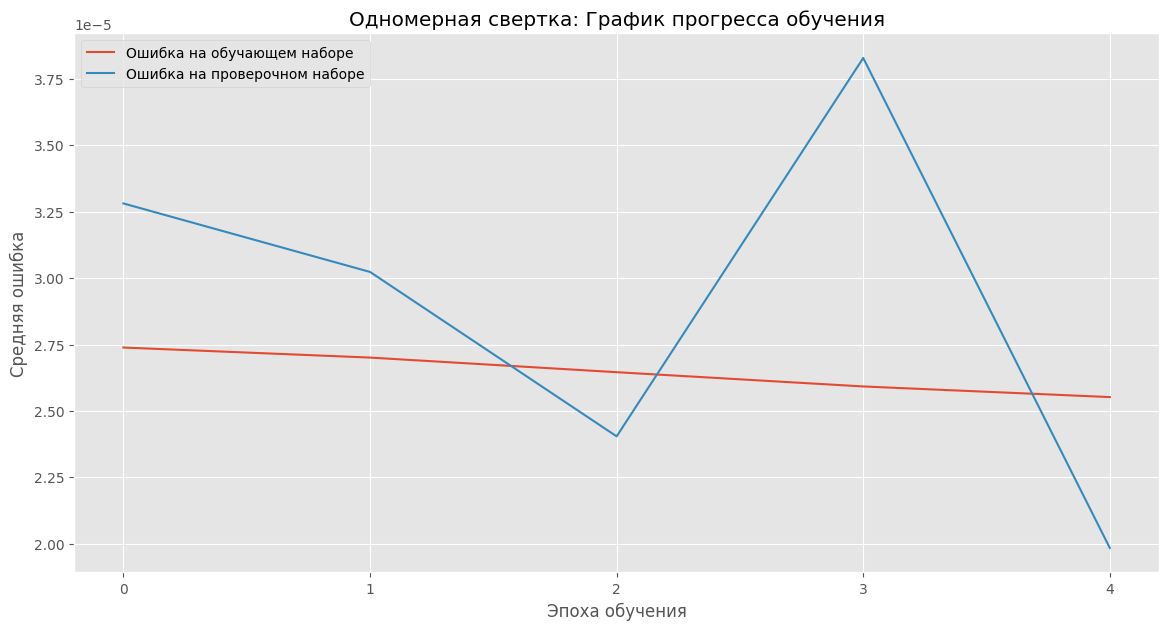

910/910 [==============================] - 2s 2ms/step


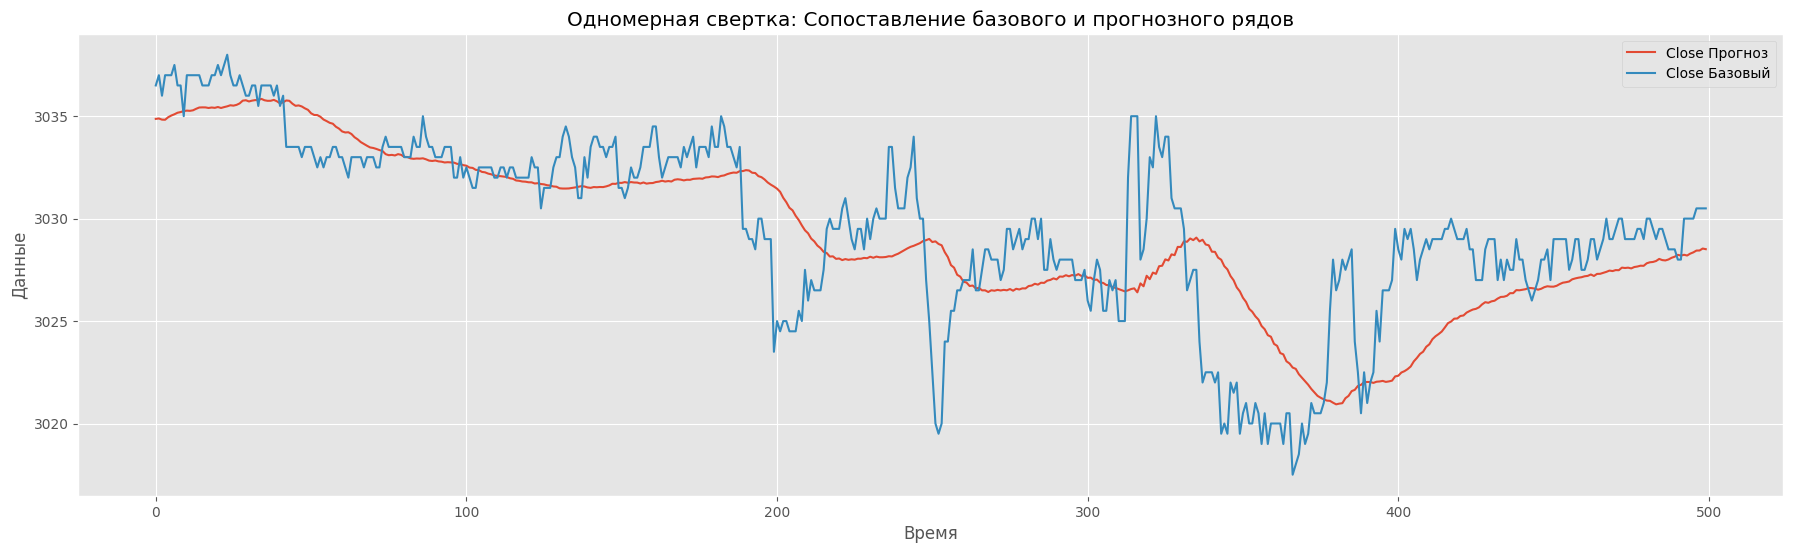

In [ ]:
model_conv = Sequential() # Модель Conv1D
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))
# Модель Conv1D обучение с разными значениями learning_rate

train_eval_net(model_conv, train_datagen, val_datagen, [(8, Adam(learning_rate=1e-4)),
                                                        (5, Adam(learning_rate=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

**Создание и обучение сети с использованием рекуррентного слоя**

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5)                 220       
                                                                 
 dense_22 (Dense)            (None, 10)                60        
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 291 (1.14 KB)
Trainable params: 291 (1.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Обучение 8 эпох
Epoch 1/8
7301/7301 [==============================] - 106s 14ms/step - loss: 0.0408 - val_loss: 1.2312e-04
Epoch 2/8
7301/7301 [==============================] - 111s 15ms/step - loss: 3.4881e-05 - val_loss: 4.6272e-06
Epoch 3/8
7301/7301 [==============================

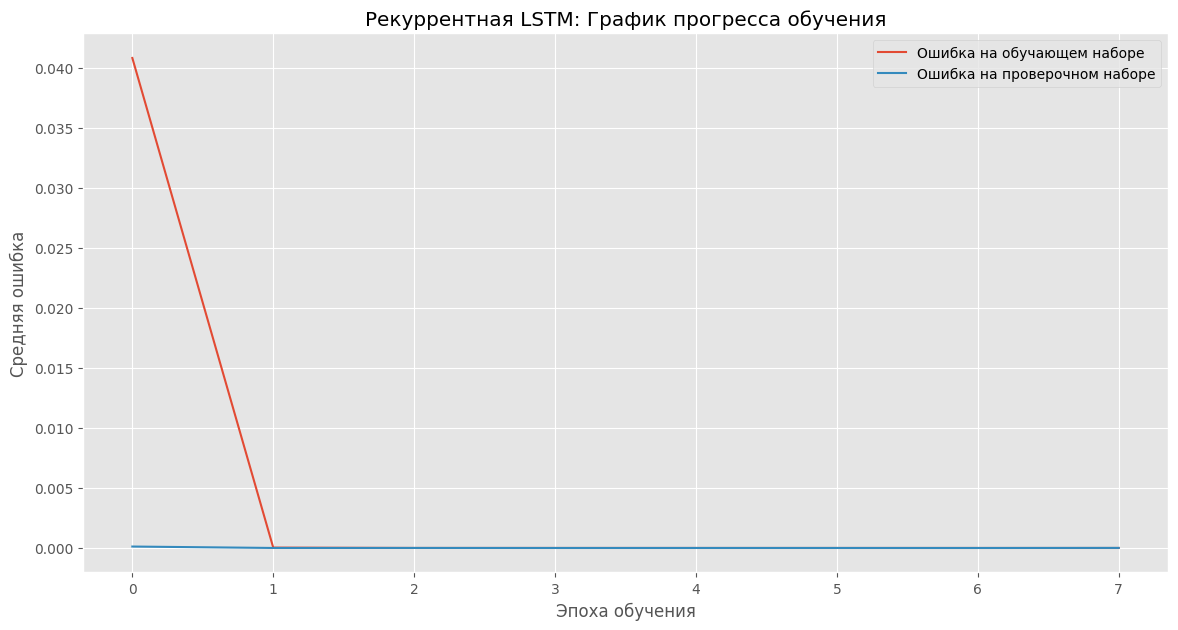

910/910 [==============================] - 5s 5ms/step


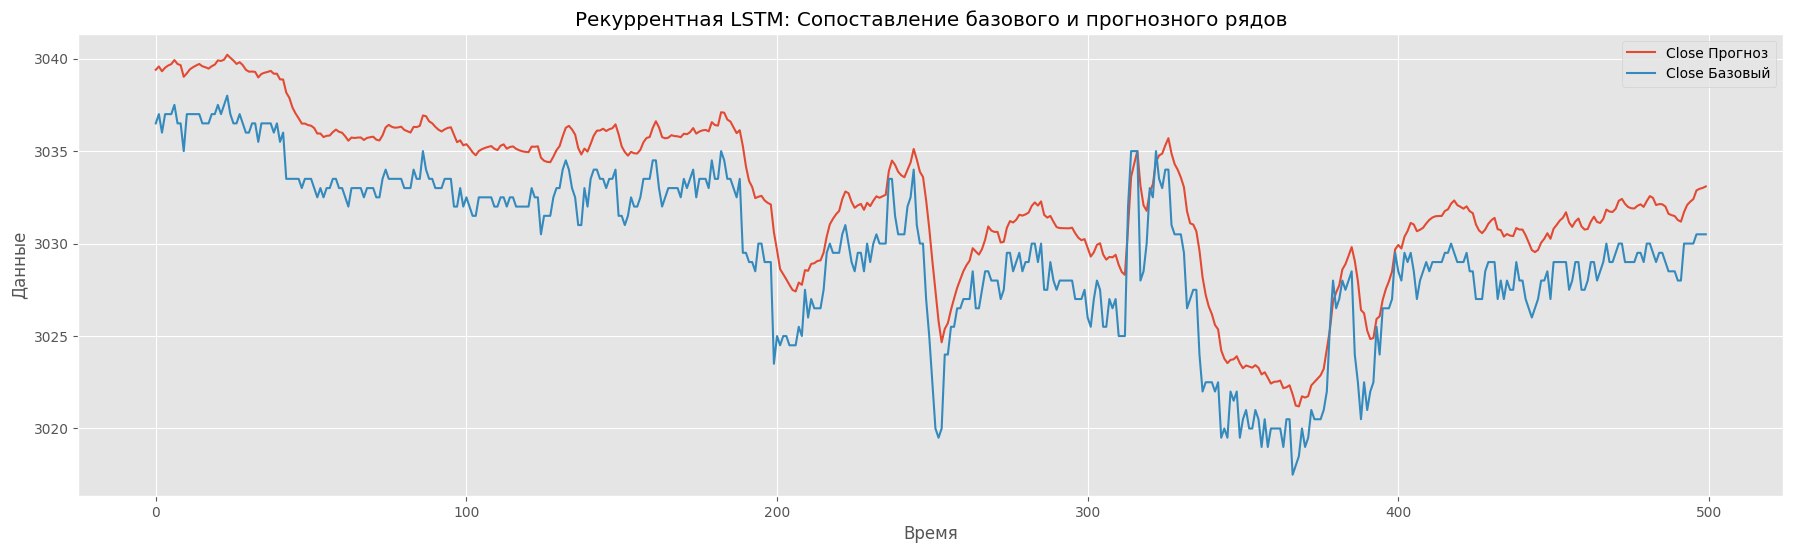

Обучение 5 эпох
Epoch 1/5
7301/7301 [==============================] - 99s 13ms/step - loss: 3.4732e-06 - val_loss: 2.9792e-06
Epoch 2/5
7301/7301 [==============================] - 96s 13ms/step - loss: 3.4475e-06 - val_loss: 2.9857e-06
Epoch 3/5
7301/7301 [==============================] - 101s 14ms/step - loss: 3.4266e-06 - val_loss: 2.9022e-06
Epoch 4/5
7301/7301 [==============================] - 110s 15ms/step - loss: 3.4234e-06 - val_loss: 2.8300e-06
Epoch 5/5
7301/7301 [==============================] - 118s 16ms/step - loss: 3.4109e-06 - val_loss: 2.8170e-06


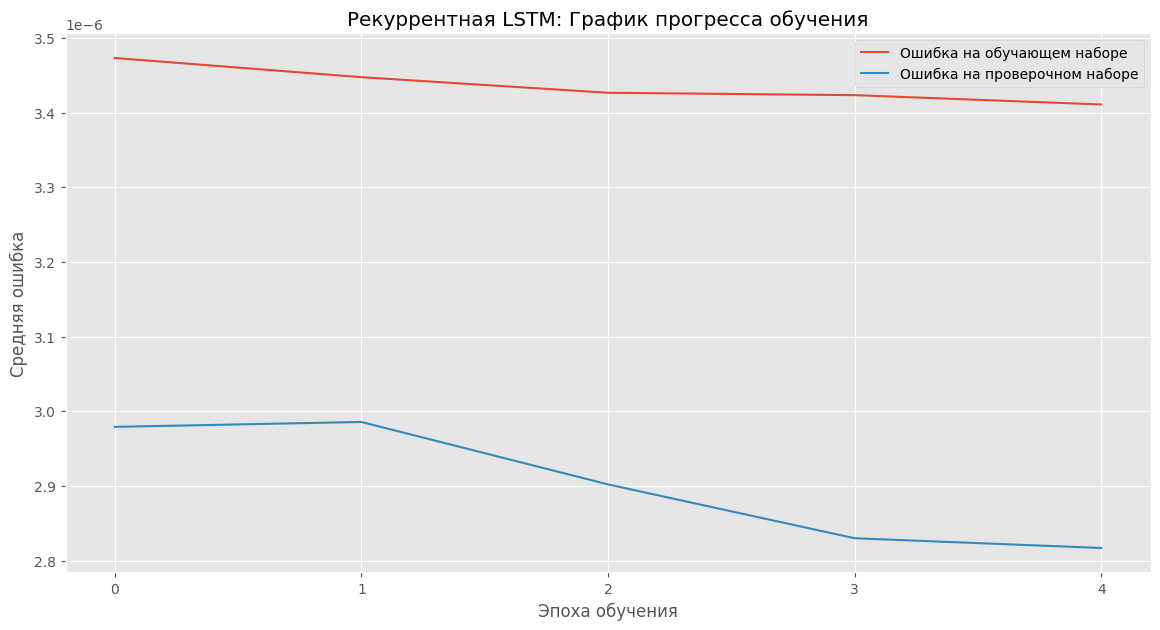

910/910 [==============================] - 8s 8ms/step


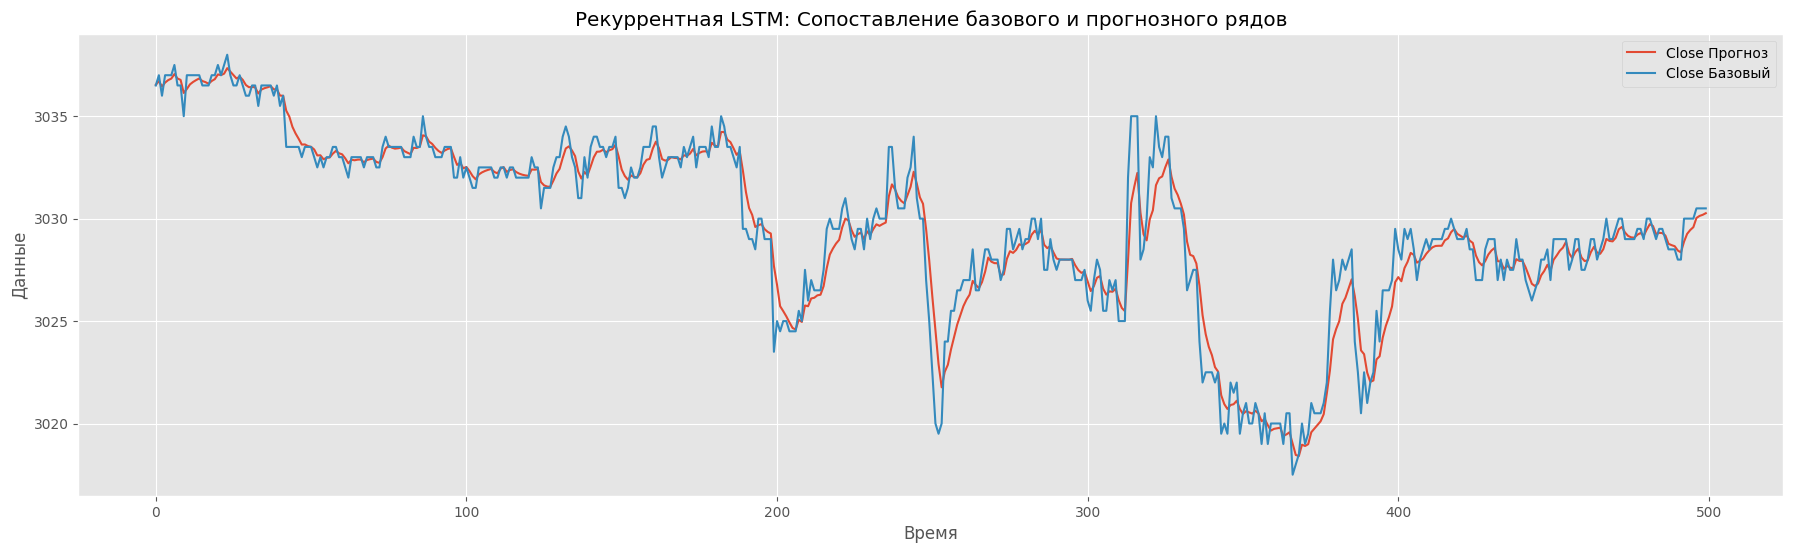

In [ ]:
model_lstm = Sequential()  # Модель LSTM
model_lstm.add(LSTM(5, input_shape=x_test.shape[1:]))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(y_test.shape[1], activation='linear'))
# Модель LSTM обучение с разными значениями learning_rate
train_eval_net(model_lstm, train_datagen, val_datagen, [(8, Adam(learning_rate=1e-4)),(5, Adam(learning_rate=1e-5))],
               x_test, y_test, y_scaler, title='Рекуррентная LSTM')

**Задание 1.**

В задании используется база курса акций Course.csv (ссылка https://drive.google.com/file/d/1LlQd1xtjO47h-GO94BK704Jp0F6h5z6I/view?usp=sharing).
1.	Создайте и  обучите простую полносвязную сеть для прогнозирования временного ряда (только показатель close) и выведите график ошибки. Постройте графики сравнения предсказания с оригинальным значением временного ряда.
2.	Создайте и обучите сверточную сеть для прогнозирования (только показатель close) и выведите график ошибки. Постройте графики сравнения предсказания с оригинальным значением временного ряда.
3.	Создайте и обучите сеть для прогнозирования с использованием LSTM слоя.
5.  Выведите лучшую архитектуру сети.



**ВОПРОСЫ**

1. Какую архитектуру сети предпочтительно использовать в задаче прогнозирования значений временных рядов?

**Ваш ответ**
LSTM (Long Short-Term Memory)




In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

 url = 'https://drive.google.com/uc?export=download&id=1LlQd1xtjO47h-GO94BK704Jp0F6h5z6I'
data = pd.read_csv(url, sep=';')
data = data.drop(columns=['DATE', 'TIME'])

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

SEQ_LEN = 300
BATCH_SIZE = 32
TRAIN_SIZE = int(len(data_scaled) * 0.8)
train_data = data_scaled[:TRAIN_SIZE]
test_data = data_scaled[TRAIN_SIZE:]

train_gen = TimeseriesGenerator(train_data, train_data[:, 3], length=SEQ_LEN, batch_size=BATCH_SIZE)
test_gen = TimeseriesGenerator(test_data, test_data[:, 3], length=SEQ_LEN, batch_size=BATCH_SIZE)


Epoch 1/20
5440/5440 [==============================] - 31s 5ms/step - loss: 0.0067 - val_loss: 3.5432e-04
Epoch 2/20
5440/5440 [==============================] - 26s 5ms/step - loss: 2.8166e-04 - val_loss: 5.1542e-05
Epoch 3/20
5440/5440 [==============================] - 22s 4ms/step - loss: 2.4690e-04 - val_loss: 5.2707e-04
Epoch 4/20
5440/5440 [==============================] - 23s 4ms/step - loss: 2.0779e-04 - val_loss: 3.3108e-05
Epoch 5/20
5440/5440 [==============================] - 24s 4ms/step - loss: 2.1819e-04 - val_loss: 7.0824e-05
Epoch 6/20
5440/5440 [==============================] - 24s 4ms/step - loss: 2.2026e-04 - val_loss: 8.7053e-05
Epoch 7/20
5440/5440 [==============================] - 27s 5ms/step - loss: 1.9463e-04 - val_loss: 2.5320e-05
Epoch 8/20
5440/5440 [==============================] - 23s 4ms/step - loss: 1.6557e-04 - val_loss: 2.1109e-05
Epoch 9/20
5440/5440 [==============================] - 22s 4ms/step - loss: 1.6877e-04 - val_loss: 1.9423e-05
Epoch

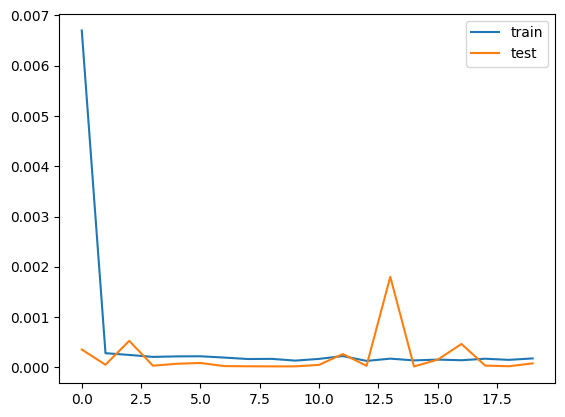

1353/1353 [==============================] - 4s 3ms/step


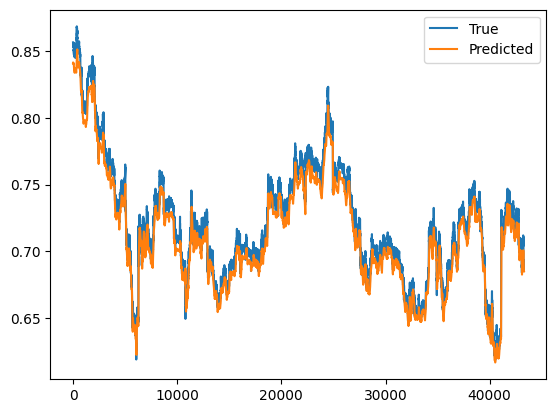

In [2]:

model_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(SEQ_LEN, train_data.shape[1])),
    Flatten(),
    Dense(1)
])

model_mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history_mlp = model_mlp.fit(train_gen, validation_data=test_gen, epochs=20)


plt.plot(history_mlp.history['loss'], label='train')
plt.plot(history_mlp.history['val_loss'], label='test')
plt.legend()
plt.show()
pred_mlp = model_mlp.predict(test_gen)
plt.plot(test_data[SEQ_LEN:, 3], label='True')
plt.plot(pred_mlp, label='Predicted')
plt.legend()
plt.show()


Epoch 1/20
5440/5440 [==============================] - 24s 4ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 2/20
5440/5440 [==============================] - 22s 4ms/step - loss: 4.1595e-04 - val_loss: 1.5706e-04
Epoch 3/20
5440/5440 [==============================] - 23s 4ms/step - loss: 3.6100e-04 - val_loss: 1.3751e-04
Epoch 4/20
5440/5440 [==============================] - 20s 4ms/step - loss: 5.2139e-04 - val_loss: 3.8962e-04
Epoch 5/20
5440/5440 [==============================] - 22s 4ms/step - loss: 2.7645e-04 - val_loss: 5.8514e-05
Epoch 6/20
5440/5440 [==============================] - 22s 4ms/step - loss: 3.4550e-04 - val_loss: 1.6195e-04
Epoch 7/20
5440/5440 [==============================] - 21s 4ms/step - loss: 2.8499e-04 - val_loss: 2.6270e-05
Epoch 8/20
5440/5440 [==============================] - 23s 4ms/step - loss: 2.6863e-04 - val_loss: 5.8317e-05
Epoch 9/20
5440/5440 [==============================] - 24s 4ms/step - loss: 2.9997e-04 - val_loss: 1.7985e-04
Epoch 10/

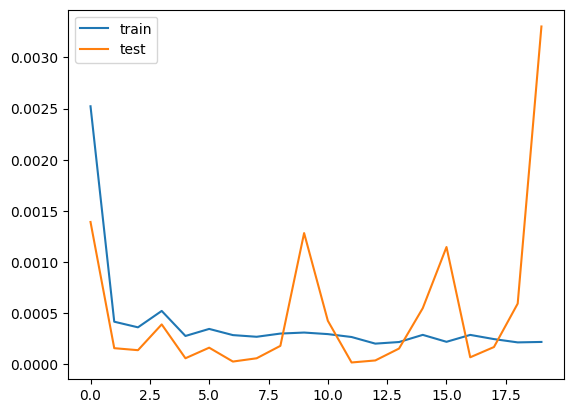

1353/1353 [==============================] - 3s 2ms/step


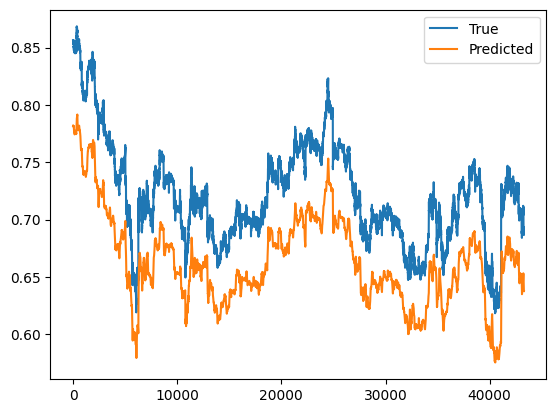

In [ ]:
model_conv = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(SEQ_LEN, train_data.shape[1])),
    Flatten(),
    Dense(1)
])

model_conv.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history_conv = model_conv.fit(train_gen, validation_data=test_gen, epochs=20)

plt.plot(history_conv.history['loss'], label='train')
plt.plot(history_conv.history['val_loss'], label='test')
plt.legend()
plt.show()

pred_conv = model_conv.predict(test_gen)
plt.plot(test_data[SEQ_LEN:, 3], label='True')
plt.plot(pred_conv, label='Predicted')
plt.legend()
plt.show()


Epoch 1/20
5440/5440 [==============================] - 70s 13ms/step - loss: 2.3248e-04 - val_loss: 1.4554e-04
Epoch 2/20
5440/5440 [==============================] - 67s 12ms/step - loss: 3.5666e-05 - val_loss: 6.8647e-06
Epoch 3/20
5440/5440 [==============================] - 79s 14ms/step - loss: 1.7485e-05 - val_loss: 2.6652e-06
Epoch 4/20
5440/5440 [==============================] - 72s 13ms/step - loss: 1.1409e-05 - val_loss: 1.7093e-06
Epoch 5/20
5440/5440 [==============================] - 71s 13ms/step - loss: 1.1808e-05 - val_loss: 1.6120e-06
Epoch 6/20
5440/5440 [==============================] - 72s 13ms/step - loss: 1.2130e-05 - val_loss: 1.5834e-06
Epoch 7/20
5440/5440 [==============================] - 72s 13ms/step - loss: 6.9006e-06 - val_loss: 2.4960e-06
Epoch 8/20
5440/5440 [==============================] - 69s 13ms/step - loss: 8.9966e-06 - val_loss: 1.2237e-05
Epoch 9/20
5440/5440 [==============================] - 75s 14ms/step - loss: 8.0218e-06 - val_loss: 2.2

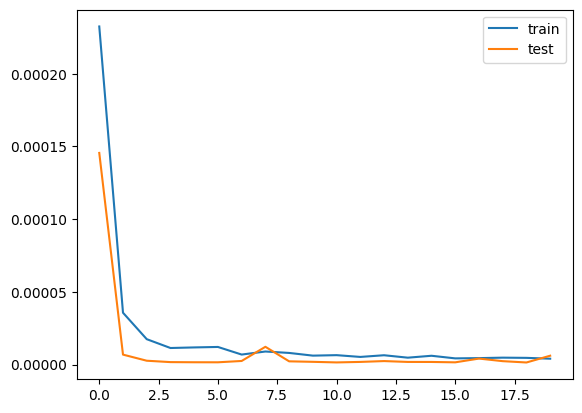

1353/1353 [==============================] - 8s 6ms/step


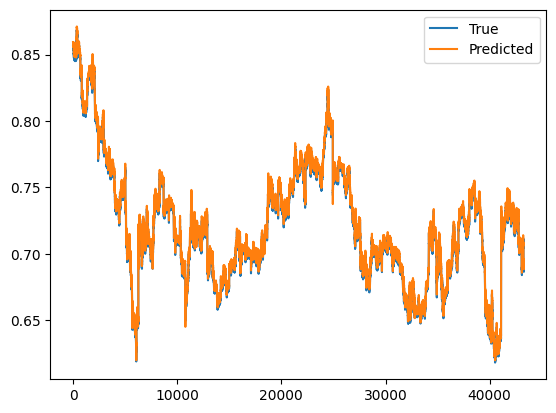

In [ ]:
model_lstm = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, train_data.shape[1])),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history_lstm = model_lstm.fit(train_gen, validation_data=test_gen, epochs=20)

plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

pred_lstm = model_lstm.predict(test_gen)
plt.plot(test_data[SEQ_LEN:, 3], label='True')
plt.plot(pred_lstm, label='Predicted')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

pred_mlp = model_mlp.predict(test_gen)
pred_conv = model_conv.predict(test_gen)
pred_lstm = model_lstm.predict(test_gen)

true_values = test_data[SEQ_LEN:, 3]

mse_mlp = mean_squared_error(true_values, pred_mlp)
mse_conv = mean_squared_error(true_values, pred_conv)
mse_lstm = mean_squared_error(true_values, pred_lstm)

print(f"MSE for MLP: {mse_mlp}")
print(f"MSE for Conv1D: {mse_conv}")
print(f"MSE for LSTM: {mse_lstm}")


1353/1353 [==============================] - 8s 6ms/step
MSE for MLP: 6.575076725540108e-05
MSE for Conv1D: 0.003303248387260398
MSE for LSTM: 6.107216522691808e-06


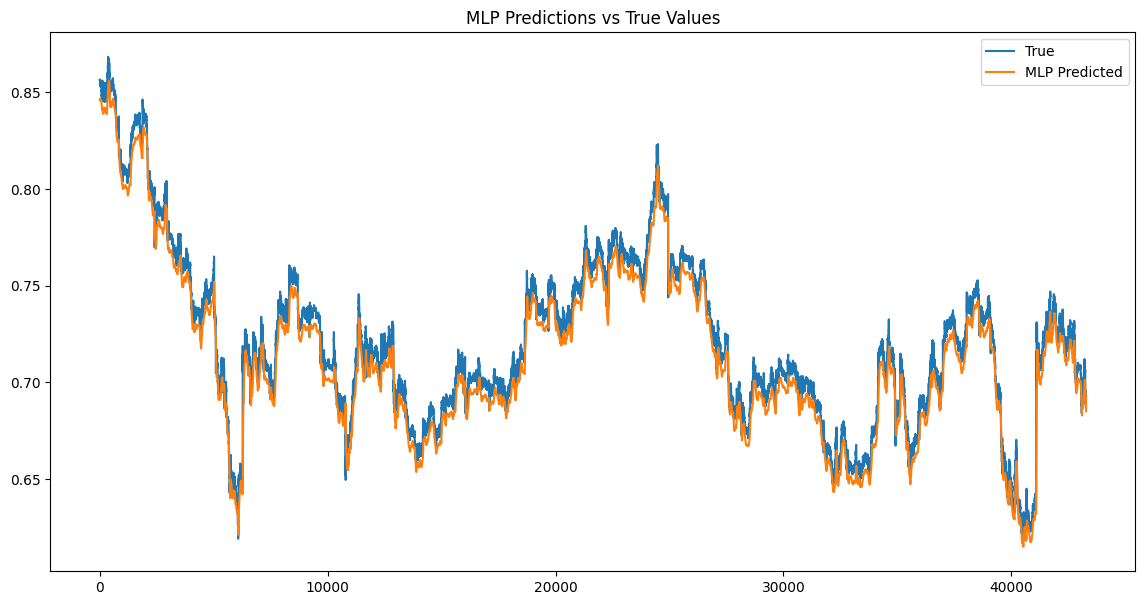

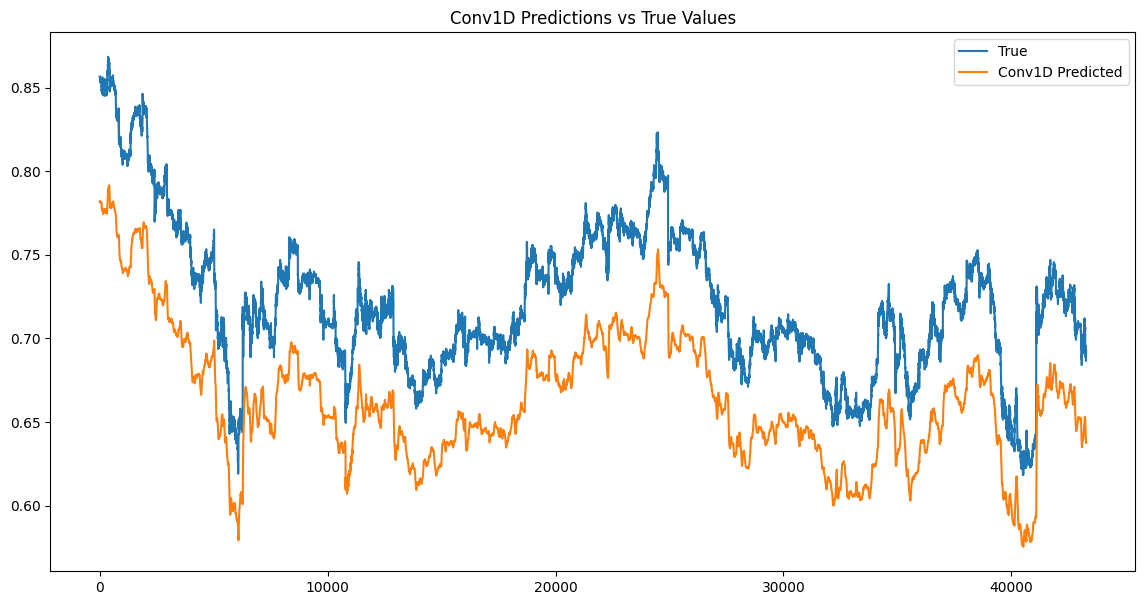

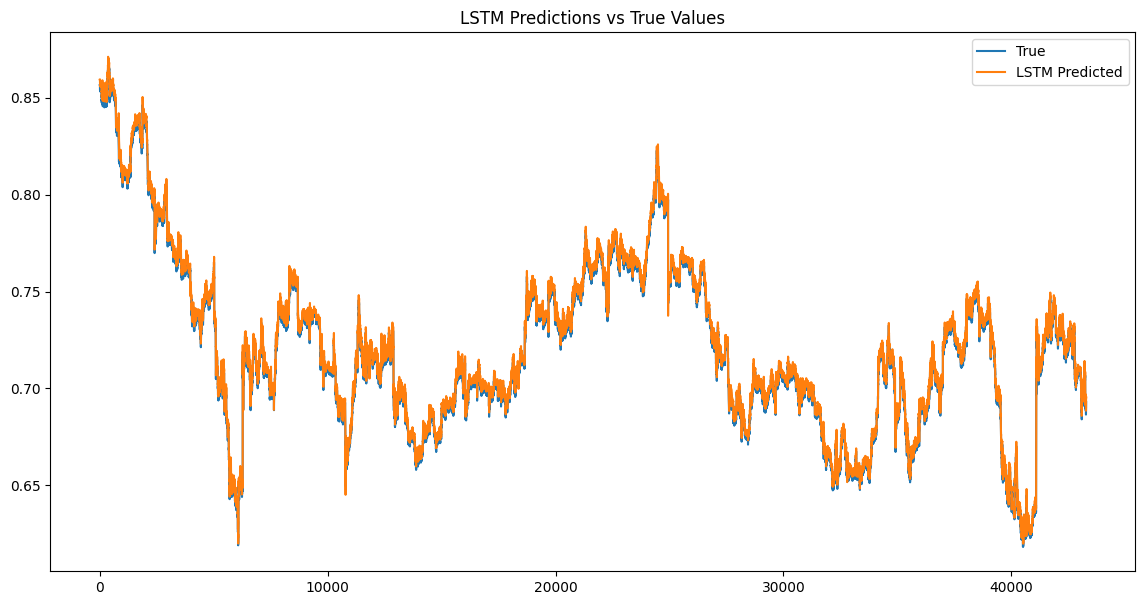

In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(true_values, label='True')
plt.plot(pred_mlp, label='MLP Predicted')
plt.title('MLP Predictions vs True Values')
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(true_values, label='True')
plt.plot(pred_conv, label='Conv1D Predicted')
plt.title('Conv1D Predictions vs True Values')
plt.legend()
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(true_values, label='True')
plt.plot(pred_lstm, label='LSTM Predicted')
plt.title('LSTM Predictions vs True Values')
plt.legend()
plt.show()


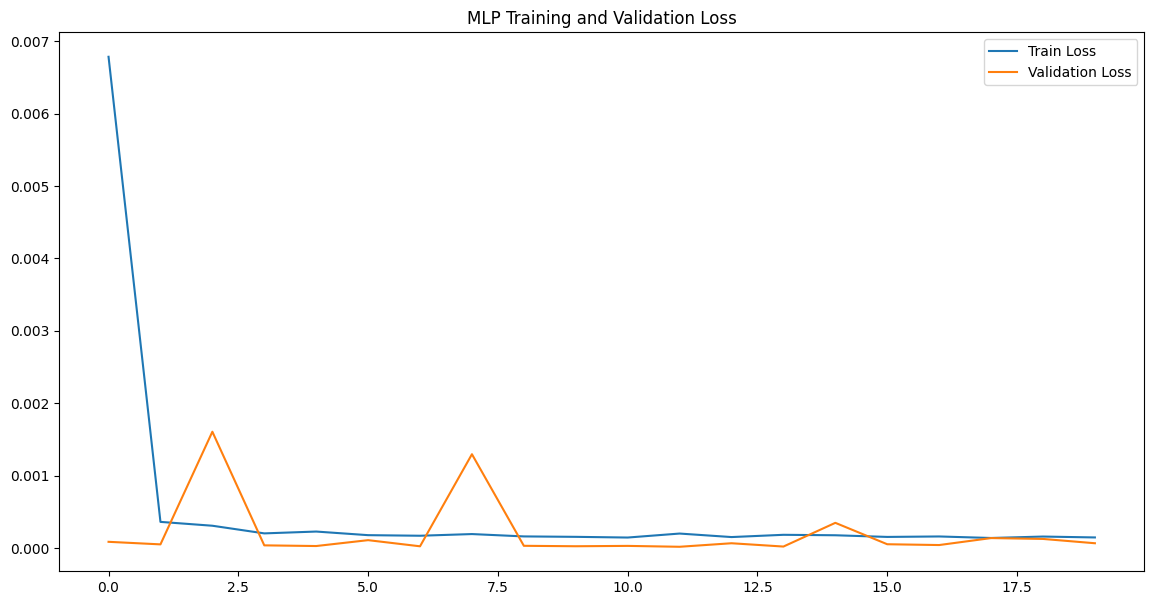

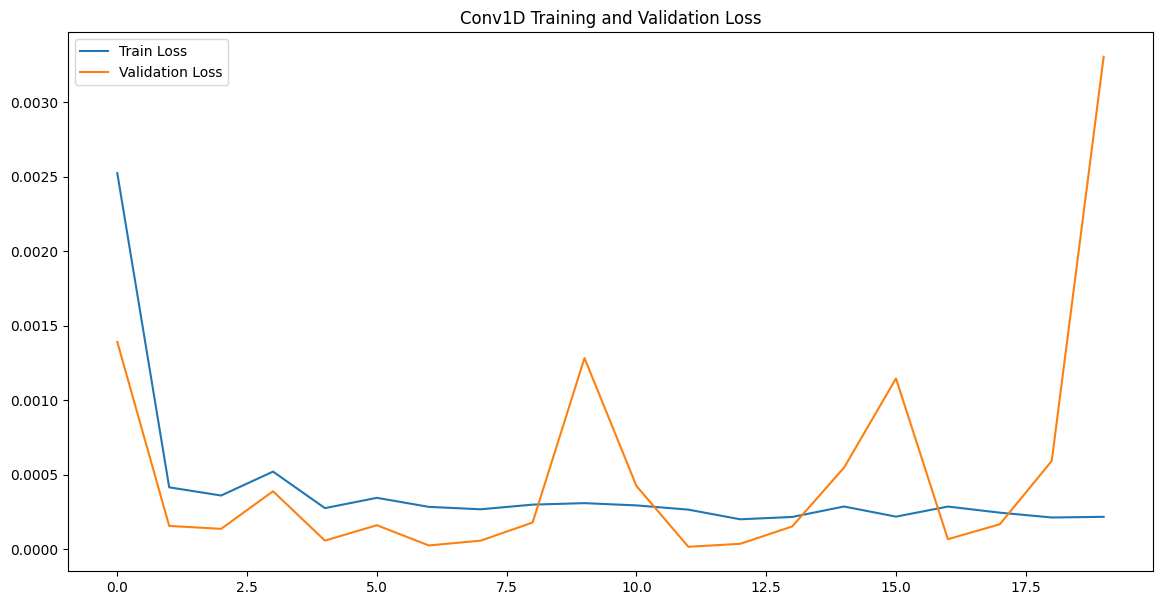

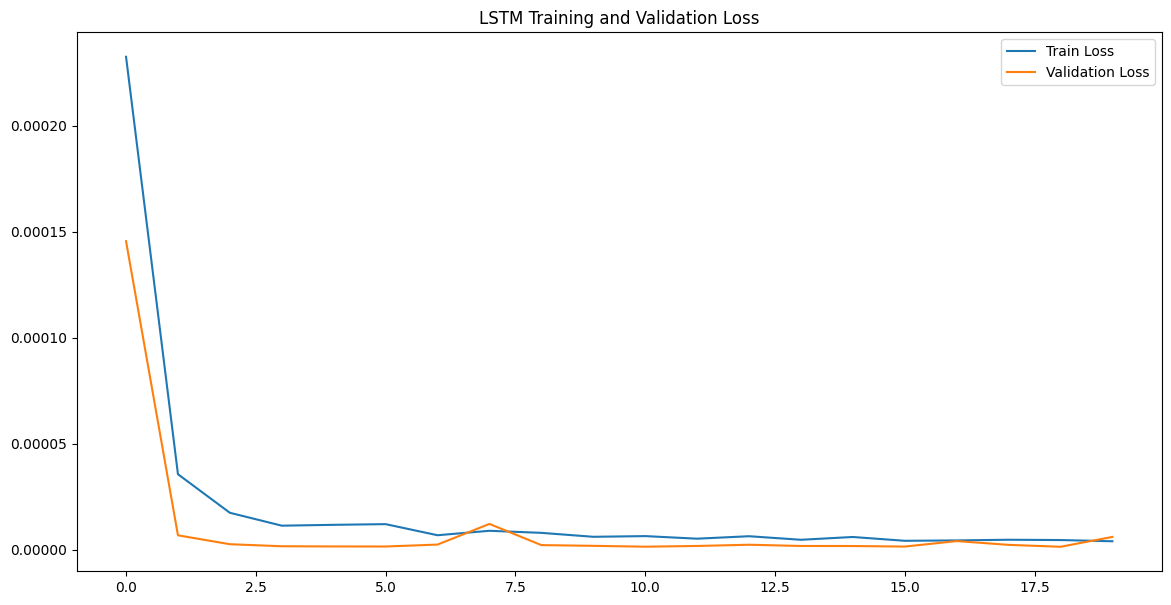

In [ ]:
# График ошибки для MLP
plt.figure(figsize=(14, 7))
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Training and Validation Loss')
plt.legend()
plt.show()

# График ошибки для Conv1D
plt.figure(figsize=(14, 7))
plt.plot(history_conv.history['loss'], label='Train Loss')
plt.plot(history_conv.history['val_loss'], label='Validation Loss')
plt.title('Conv1D Training and Validation Loss')
plt.legend()
plt.show()

# График ошибки для LSTM
plt.figure(figsize=(14, 7))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()
